In [3]:
from integer_linear_problem import Ilp
from config import Config
import pandas as pd
import numpy as np
import math
import scipy.stats as stats
import matplotlib.pyplot as plt
import functools
import time

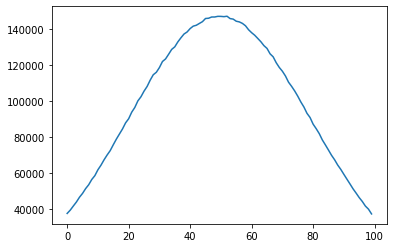

In [4]:
a, b = 500, 600
mu, sigma = 550, 30
dist = stats.truncnorm((a - mu) / sigma, (b - mu) / sigma, loc=mu, scale=sigma)
values: np.ndarray = dist.rvs(10000000).astype(int)
values.sort()

count_arr = np.zeros(10000000)
for val in values:
    count_arr[val] += 1
plt.plot(count_arr[500:600])

In [9]:
from datetime import datetime
import json
import os
from integer_linear_problem import Ilp
from config import Config
import pandas as pd
import numpy as np
import math
import scipy.stats as stats
import matplotlib.pyplot as plt
import ilp_solver
from intuitive_algo_2 import intuitive_algo_2
from solution import Flags
import utils

ILP_SMALL = Ilp.from_excel(Config().DATA_SMALL_PATH)
ILP_LARGE = Ilp.from_excel(Config().DATA_LARGE_PATH)

def gen_ilp(n, w_mu, w_sigma, c_mu, c_sigma, f_mu, f_sigma, collection, transfer, distribution):
    w_arr = np.random.normal(loc=w_mu, scale=w_sigma, size=n**2).astype(int)

    # ensure all values are >= 0
    while any(w_arr < 0):
        w_arr[w_arr < 0] = np.random.normal(loc=w_mu, scale=w_sigma, size=sum(w_arr < 0)).astype(int)

    w_iter = iter(w_arr)
    w_dct = dict()
    for i in range(1, n + 1):
        w_dct[i] = dict()
        for j in range(1, n + 1):
            w_dct[i][j] = next(w_iter)

    c_arr = np.random.normal(loc=c_mu, scale=c_sigma, size=n**2 - n).astype(int) # FIXME: the mean and standard deviation don't seem to converge to mu and sigma, https://stackoverflow.com/questions/27831923/python-random-number-generator-with-mean-and-standard-deviation

    # ensure all values are > 0
    # FIXME: this throws the mean and std even more off...
    # FIXME: make costs symmetrical
    while any(c_arr <= 0):
        c_arr[c_arr <= 0] = np.random.normal(loc=c_mu, scale=c_sigma, size=sum(c_arr <= 0)).astype(int)

    c_iter = iter(c_arr)
    c_dct = dict()
    for i in range(1, n + 1):
        c_dct[i] = dict()
        for j in range(1, n + 1):
            if i == j:
                c_dct[i][j] = 0
            else:
                c_dct[i][j] = next(c_iter)

    f_arr = np.random.normal(loc=f_mu, scale=f_sigma, size=n).astype(int)

    # ensure all values are > 0
    while any(f_arr <= 0):
        f_arr[f_arr <= 0] = np.random.normal(loc=f_mu, scale=f_sigma, size=sum(f_arr <= 0)).astype(int)

    f_iter = iter(f_arr)
    f_dct = {i: next(f_iter) for i in range(1, n + 1)}

    N = set(range(1, n + 1))
    ilp = Ilp(N, collection, transfer, distribution, w_dct, c_dct, f_dct)

    return ilp

def get_params_nd():


    # merge small and large data set (also make them of the same size) and calculate mean and standard deviation seperately for flow, costs and fixed costs
    w_small_ser = ILP_SMALL.w_df.stack()
    w_large_ser = ILP_LARGE.w_df.stack()
    
    w_small_ser = pd.concat([w_small_ser] * math.ceil(len(w_large_ser) / len(w_small_ser)))
    w_small_ser = w_small_ser[:len(w_large_ser)]

    w_ser = pd.concat([w_small_ser, w_large_ser])
    w_mu = w_ser.mean()
    w_sigma = w_ser.std()

    # exclude zeros for mean and std
    c_small_ser = ILP_SMALL.c_df.stack()
    c_small_ser = c_small_ser[c_small_ser != 0]
    c_large_ser = ILP_LARGE.c_df.stack()
    c_large_ser = c_large_ser[c_large_ser != 0]

    c_small_ser = pd.concat([c_small_ser] * math.ceil(len(c_large_ser) / len(c_small_ser)))
    c_small_ser = c_small_ser[:len(c_large_ser)]

    c_ser = pd.concat([c_small_ser, c_large_ser])
    c_mu = c_ser.mean()
    c_sigma = c_ser.std()

    f_small_ser = ILP_SMALL.f_ser
    f_large_ser = ILP_LARGE.f_ser

    f_small_ser = pd.concat([f_small_ser] * math.ceil(len(f_large_ser) / len(f_small_ser)))
    f_small_ser = f_small_ser[:len(f_large_ser)]

    f_ser: pd.Series = pd.concat([f_small_ser, f_large_ser])
    f_mu = f_ser.mean()
    f_sigma = f_ser.std()

    return w_mu, w_sigma, c_mu, c_sigma, f_mu, f_sigma

def rank_algos(min_dataset_n = 10, max_dataset_n = 15, samples = 20):
    w_mu, w_sigma, c_mu, c_sigma, f_mu, f_sigma = get_params_nd()

    gui_data = []
    # calculate and display average error percentage for different sizes n of the data sets # TODO: how to calculate this?
    error_df = pd.DataFrame(
        np.zeros((max_dataset_n - min_dataset_n + 1, samples)), 
        index=range(min_dataset_n, max_dataset_n + 1),
    )
    # TODO: add good logs, good time estimates how long it will take and store the data
    # TODO: create folder (in out/algo_rankings or smth) with all solution directories generated by calling rank_algos() once
    date = datetime.now()
    utils.ensure_dir_exists(Config().ALGO_PERFORMANCE_RANKING_DIR_PATH)
    save_id = utils.count_dirs(Config().ALGO_PERFORMANCE_RANKING_DIR_PATH)
    algo_dir_path = Config().ALGO_PERFORMANCE_RANKING_DIR_PATH / fr'{save_id}-{utils.get_formatted_date("-", date)}'
    counter = 0
    for n in range(min_dataset_n, max_dataset_n + 1):
        for i in range(samples):
            counter += 1

            ilp = gen_ilp(n, w_mu, w_sigma, c_mu, c_sigma, f_mu, f_sigma, ILP_SMALL.collection, ILP_SMALL.transfer, ILP_SMALL.distribution)
            sol_gurobi = ilp_solver.gurobi_v1(ilp, Flags.VISUALISE | Flags.SAVE, algo_dir_path=algo_dir_path)
            sol_heuristic_2 = intuitive_algo_2(ilp, Flags.VISUALISE | Flags.SAVE, algo_dir_path=algo_dir_path)
            gui_data.append({
                'name': f'Random Dataset {counter}',
                'ilpF': ilp.f,
                'ilpW': ilp.w,
                'ilpC': ilp.c,
                'gurobiZ': sol_gurobi.z,
                'heuristic2Z': sol_heuristic_2.z,
                # FIXME: refactor
                'gurobiGraphPath': next(file for file in next(os.walk(sol_gurobi.save_dir_path))[2] if '.html' in file),
                'heuristic2GraphPath': next(file for file in next(os.walk(sol_heuristic_2.save_dir_path))[2] if '.html' in file),
                'gurobiRuntime': sol_gurobi.timer.total_time,
                'heuristic2Runtime': sol_heuristic_2.timer.total_time,
            })
            error_df.loc[n][i] = (sol_gurobi.z - sol_heuristic_2.z) / sol_heuristic_2.z * 100

    print(error_df)
    print(error_df.stack().describe())

    avg_error_ser = pd.Series(np.zeros((max_dataset_n - min_dataset_n + 1,)), index=range(min_dataset_n, max_dataset_n + 1))
    for index, row in error_df.iterrows():
        avg_error_ser[index] = row.mean()
    print(avg_error_ser)
    print(avg_error_ser.describe())
    return gui_data
    gui_data_path = algo_dir_path / r'guiData.json'
    # with open(gui_data_path, 'w') as file:
    #     json.dump(gui_data, file)

def main() -> None:
    return rank_algos(7, 7, 1)


gui_data = main()

c:\Users\Thom van den Hil\Desktop\Modelling-B\venv\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


The solution is successfully saved to c:\Users\Thom van den Hil\Desktop\Modelling-B\src\out\algo-performance-ranking\6-2022-06-08-15-21-30\1-2022-06-08-15-18-14.


calculating (sub)optimal solution: 100it [00:00, 448.44it/s]                                        


The solution is successfully saved to c:\Users\Thom van den Hil\Desktop\Modelling-B\src\out\algo-performance-ranking\6-2022-06-08-15-21-30\2-2022-06-08-15-18-14.
     0
7  0.0
count    1.0
mean     0.0
std      NaN
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
dtype: float64
7    0.0
dtype: float64
count    1.0
mean     0.0
std      NaN
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
dtype: float64


In [22]:
# print(gui_data)
for index, item in enumerate(gui_data):
    for key, val in item.items():
        if val not in ('ilpF', 'ilpW', 'ilpC'):
            continue
        gui_data[index][key] = utils.dict_dtypes_to_int(item)

print(list(gui_data[0]['ilpF'].values())[0])
print(type(list(gui_data[0]['ilpF'].values())[0]))
with open('TEST_DETELET.JSON', 'w') as file:
    json.dump(gui_data, file)

23992
<class 'numpy.int32'>


TypeError: Object of type int32 is not JSON serializable

In [27]:
ilp = Ilp.from_excel(Config().DATA_SMALL_PATH)
print(ilp.c_df.to_dict())
with open('TEST_DETELET.JSON', 'w') as file:
    json.dump(ilp.c_df.to_dict(), file)

{1: {1: 0, 2: 20, 3: 16, 4: 23, 5: 23, 6: 30, 7: 32, 8: 33, 9: 36, 10: 36}, 2: {1: 20, 2: 0, 3: 20, 4: 13, 5: 25, 6: 19, 7: 30, 8: 25, 9: 38, 10: 31}, 3: {1: 16, 2: 20, 3: 0, 4: 14, 5: 7, 6: 19, 7: 16, 8: 18, 9: 21, 10: 21}, 4: {1: 23, 2: 13, 3: 14, 4: 0, 5: 14, 6: 7, 7: 18, 8: 13, 9: 27, 10: 18}, 5: {1: 23, 2: 25, 3: 7, 4: 14, 5: 0, 6: 16, 7: 9, 8: 13, 9: 14, 10: 14}, 6: {1: 30, 2: 19, 3: 19, 4: 7, 5: 16, 6: 0, 7: 16, 8: 8, 9: 25, 10: 13}, 7: {1: 32, 2: 30, 3: 16, 4: 18, 5: 9, 6: 16, 7: 0, 8: 9, 9: 10, 10: 7}, 8: {1: 33, 2: 25, 3: 18, 4: 13, 5: 13, 6: 8, 7: 9, 8: 0, 9: 18, 10: 5}, 9: {1: 36, 2: 38, 3: 21, 4: 27, 5: 14, 6: 25, 7: 10, 8: 18, 9: 0, 10: 14}, 10: {1: 36, 2: 31, 3: 21, 4: 18, 5: 14, 6: 13, 7: 7, 8: 5, 9: 14, 10: 0}}
